In [2]:
import numpy as np 
import pandas as pd 
import os 
from PIL import Image 
from skimage.io import imread
import torch 
from torch.utils.data.dataset import Dataset
import torchvision as tv 

In [3]:
import matplotlib.pyplot as plt

In [4]:
class ADNIDataset(Dataset): 
    def __init__(self, csv_path, base_path='/home/aay993/bias_corrected_registered_slices/', crop_type=None, crop_size=(192, 192), downsample: int = None):
        super().__init__()
        self.csv_path = csv_path 
        self.base_path = base_path

        self.crop_type = crop_type
        self.crop_size = crop_size

        self.downsample = downsample

        csv = pd.read_csv(csv_path)

        #get the length of the dataset for __len__
        self.num_items = len(csv)
    
        self.metrics = {col: torch.as_tensor(csv[col]).float() if col != 'PTID' else csv[col] for col in csv.columns} # For now just not even converting to tensors
        

    def __len__(self):
        return self.num_items
    
    def __getitem__(self, index): 
        item = {col: values[index] for col, values in self.metrics.items()}

        img_path = os.path.join(self.base_path, f'slice_{int(item["slice_number"])}_bias_corrected_registered_ADNI_{item["PTID"]}.png')
        img = torch.tensor(imread(img_path, as_gray=True), dtype=torch.float32)
        
        # img = Image.open(img_path).convert('L')

        # clip image border from PNG files 
        border_clip = 8 
        img = img[border_clip:-border_clip, border_clip:-border_clip]
        
        transform_list = []
        transform_list += [tv.transforms.ToPILImage()]
        if self.crop_type is not None:
            if self.crop_type == 'center':
                transform_list += [tv.transforms.CenterCrop(self.crop_size)]
            elif self.crop_type == 'random':
                transform_list += [tv.transforms.RandomCrop(self.crop_size)]
            else:
                raise ValueError('unknwon crop type: {}'.format(self.crop_type))

        if self.downsample is not None and self.downsample > 1:
            transform_list += [tv.transforms.Resize(tuple(np.array(self.crop_size) // self.downsample))]

        transform_list += [tv.transforms.ToTensor()]

        img = tv.transforms.Compose(transform_list)(img)

        item['image'] = img 

        return item 

torch.Size([1, 1, 192, 192])
{'PTID': ['016_S_5251'], 'AGE': tensor([66.1000]), 'PTGENDER': tensor([1.]), 'PTEDUCAT': tensor([16.]), 'APOE4': tensor([1.]), 'FDG': tensor([1.1985]), 'AV45': tensor([1.5072]), 'TAU': tensor([708.]), 'PTAU': tensor([70.4500]), 'CDRSB': tensor([2.5000]), 'ADAS11': tensor([12.]), 'ADAS13': tensor([18.]), 'ADASQ4': tensor([5.]), 'MMSE': tensor([26.]), 'RAVLT_immediate': tensor([28.]), 'RAVLT_learning': tensor([1.]), 'RAVLT_forgetting': tensor([4.]), 'RAVLT_perc_forgetting': tensor([80.]), 'LDELTOTAL': tensor([1.]), 'TRABSCOR': tensor([300.]), 'FAQ': tensor([15.]), 'MOCA': tensor([19.]), 'EcogPtMem': tensor([2.8571]), 'EcogPtLang': tensor([1.]), 'EcogPtVisspat': tensor([1.]), 'EcogPtPlan': tensor([1.2000]), 'EcogPtOrgan': tensor([1.]), 'EcogPtDivatt': tensor([1.]), 'EcogPtTotal': tensor([1.3889]), 'EcogSPMem': tensor([1.7500]), 'EcogSPLang': tensor([1.1111]), 'EcogSPVisspat': tensor([1.2857]), 'EcogSPPlan': tensor([1.8000]), 'EcogSPOrgan': tensor([2.]), 'EcogS

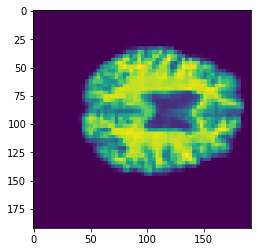

In [5]:
from torch.utils.data import DataLoader
csv_path = '/home/aay993/full_imputed_clinical_covariates.csv'
training = ADNIDataset(csv_path, crop_type='random', downsample=1)
loader = DataLoader(training, batch_size=1, shuffle=True)

test = next(iter(loader))
# plt.imshow(test['image'])
plt.imshow(test['image'].squeeze())
print(test['image'].shape)
print(test)

In [27]:
split_dir = '/home/aay993/'
data_dir = '/home/aay993/bias_corrected_registered_slices/'
downsample = 1

# For now just using the same data for all three things 
adni_train = ADNIDataset(f'{split_dir}/full_imputed_clinical_covariates.csv', base_path=data_dir, crop_type='center', downsample=downsample)  # noqa: E501
adni_val = ADNIDataset(f'{split_dir}/full_imputed_clinical_covariates.csv', base_path=data_dir, crop_type='center', downsample=downsample)
adni_test = ADNIDataset(f'{split_dir}/full_imputed_clinical_covariates.csv', base_path=data_dir, crop_type='center', downsample=downsample)

adni_train.metrics['slice_number'].max()


tensor(10.)